In [ ]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
class QGRU(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.sin(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.cos(inputs ** 2), rotation='Z', wires=wires)


    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
            #print("Weights shape:", weights.shape)


            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)


    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=4,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend='default.qubit'):
        super(QGRU, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state


        # Define the quantum circuits for each gate

        self.dev_reset = qml.device('default.qubit', wires=range(self.n_qubits))
        self.dev_update = qml.device('default.qubit', wires=range(self.n_qubits))
        self.dev_new = qml.device('default.qubit', wires=range(self.n_qubits))


        # Reset gate
        def _circuit_reset(inputs, weights):
            self.custom_encoding(inputs, wires=range(self.n_qubits))
            self.custom_entangler_layer(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=w)) for w in range(self.n_qubits)]
        self.qlayer_reset = qml.QNode(_circuit_reset, self.dev_reset, interface="torch")

        # Update gate
        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=range(self.n_qubits))
            self.custom_entangler_layer(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=w)) for w in range(self.n_qubits)]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        # New gate
        def _circuit_new(inputs, weights):
            self.custom_encoding(inputs, wires=range(self.n_qubits))
            self.custom_entangler_layer(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=w)) for w in range(self.n_qubits)]
        self.qlayer_new = qml.QNode(_circuit_new, self.dev_new, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)

        self.VQC = {
            'reset': qml.qnn.TorchLayer(self.qlayer_reset, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'new': qml.qnn.TorchLayer(self.qlayer_new, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)


    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)  # hidden state
        else:
            h_t = init_states  # assuming init_states is just the hidden state for GRU

        output_seq = []

        for t in range(seq_length):
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            #print("Shape of concatenated input v_t:", v_t.shape)
            #print("Weight shape of clayer_in:", self.clayer_in.weight.shape)
            # match qubit dimension
            v_t = self.clayer_in(v_t)
            #print("Shape after clayer_in:", v_t.shape)
            # Calculate reset and update gates
            r_t = torch.sigmoid(self.clayer_out(self.VQC['reset'](v_t)))  # reset gate
            z_t = torch.sigmoid(self.clayer_out(self.VQC['update'](v_t)))  # update gate

            # Calculate new gate content
            combined_r = r_t * h_t
            v_t_new = torch.cat((combined_r, x_t), dim=1)
            y_t_new = self.clayer_in(v_t_new)
            h_tilde = torch.tanh(self.clayer_out(self.VQC['new'](y_t_new)))  # new gate

            # Compute the new hidden state
            h_t = z_t * h_t + (1 - z_t) * h_tilde

            if self.return_sequences:
                output_seq.append(h_t.unsqueeze(1))

        if self.return_sequences:
            output_seq = torch.cat(output_seq, dim=1)  # Concatenate the output for all timesteps
            return output_seq
        else:
            return h_t

LSTM hidden layer size: 4
Number of qubits: 4
Training epochs: 100
Learning rate: 0.01
RMSprop alpha: 0.99
RMSprop eps: 1e-08
sample size: 250
sequence length: 4
input size: 2
Tagger will use Quantum GRU running on backend default.qubit
Sequence 0:
tensor([[ 1.0000, -0.0026],
        [ 0.9318,  0.0049],
        [ 0.7698,  0.0256],
        [ 0.5389,  0.0548]])
Corresponding label: tensor([0.2671, 0.0860])

Sequence 1:
tensor([[0.9318, 0.0049],
        [0.7698, 0.0256],
        [0.5389, 0.0548],
        [0.2671, 0.0860]])
Corresponding label: tensor([-0.0214,  0.1122])

Sequence 2:
tensor([[ 0.7698,  0.0256],
        [ 0.5389,  0.0548],
        [ 0.2671,  0.0860],
        [-0.0214,  0.1122]])
Corresponding label: tensor([-0.3066,  0.1266])

Epoch 1, Train Loss: 0.2567, Test Loss: 0.0801


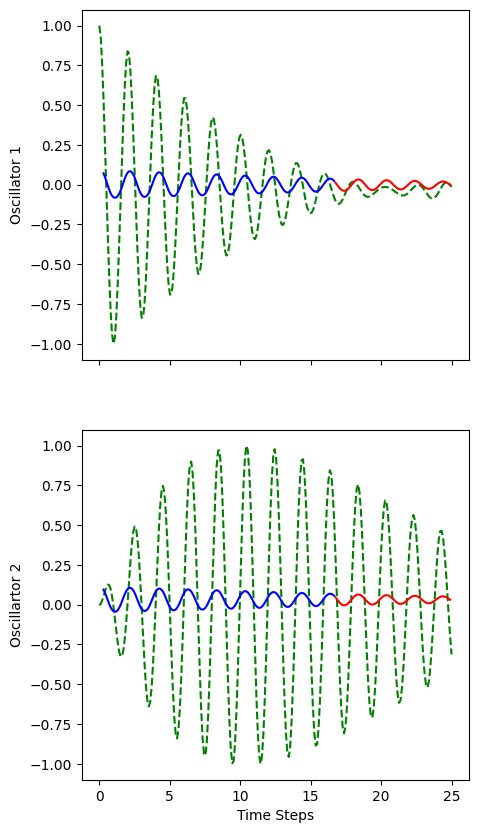

Epoch 2, Train Loss: 0.1915, Test Loss: 0.0499


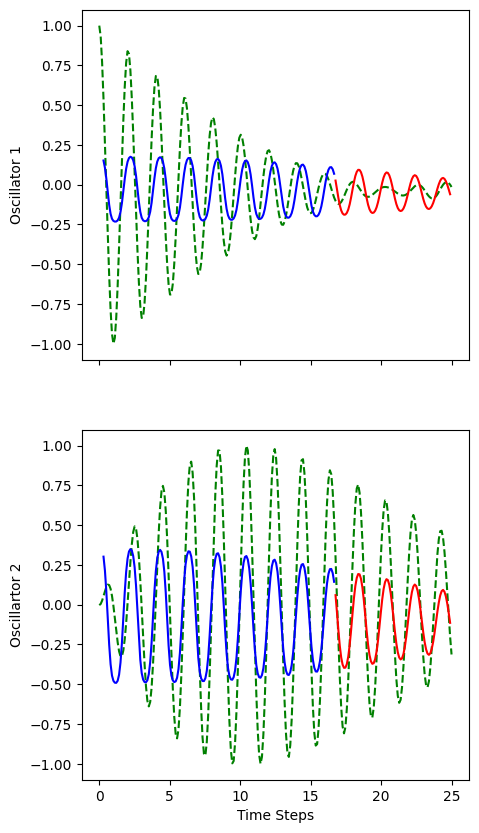

Epoch 3, Train Loss: 0.1298, Test Loss: 0.0507
Epoch 4, Train Loss: 0.0951, Test Loss: 0.0320
Epoch 5, Train Loss: 0.0905, Test Loss: 0.0305


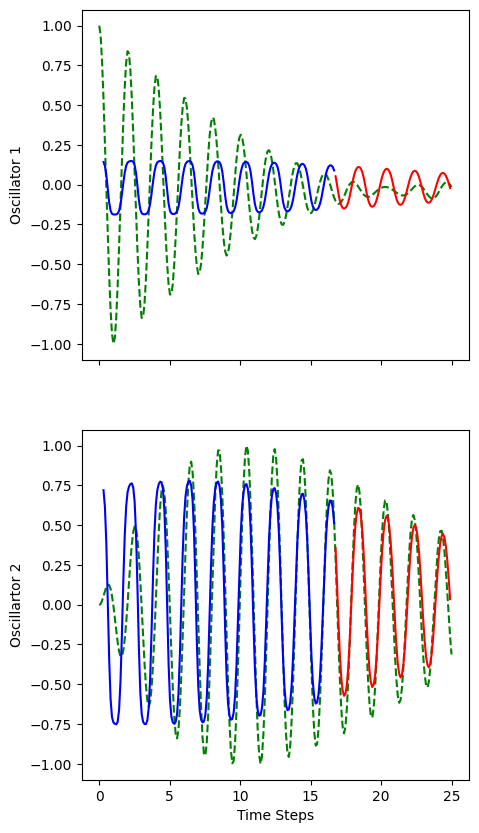

Epoch 6, Train Loss: 0.0890, Test Loss: 0.0290
Epoch 7, Train Loss: 0.0874, Test Loss: 0.0278
Epoch 8, Train Loss: 0.0858, Test Loss: 0.0268
Epoch 9, Train Loss: 0.0841, Test Loss: 0.0259
Epoch 10, Train Loss: 0.0825, Test Loss: 0.0251


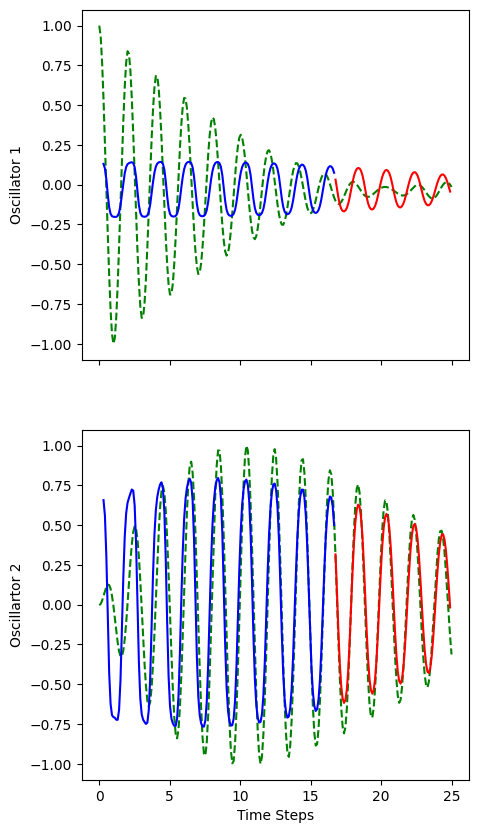

Epoch 11, Train Loss: 0.0808, Test Loss: 0.0243
Epoch 12, Train Loss: 0.0791, Test Loss: 0.0237
Epoch 13, Train Loss: 0.0774, Test Loss: 0.0230
Epoch 14, Train Loss: 0.0756, Test Loss: 0.0224
Epoch 15, Train Loss: 0.0738, Test Loss: 0.0219
Epoch 16, Train Loss: 0.0719, Test Loss: 0.0213
Epoch 17, Train Loss: 0.0700, Test Loss: 0.0208
Epoch 18, Train Loss: 0.0680, Test Loss: 0.0203
Epoch 19, Train Loss: 0.0661, Test Loss: 0.0199
Epoch 20, Train Loss: 0.0640, Test Loss: 0.0194


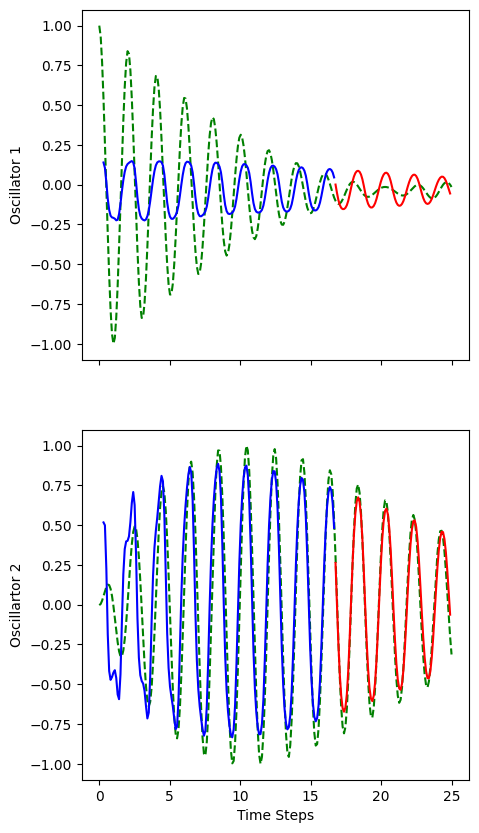

Epoch 21, Train Loss: 0.0619, Test Loss: 0.0190
Epoch 22, Train Loss: 0.0596, Test Loss: 0.0186
Epoch 23, Train Loss: 0.0571, Test Loss: 0.0183
Epoch 24, Train Loss: 0.0545, Test Loss: 0.0180
Epoch 25, Train Loss: 0.0518, Test Loss: 0.0177
Epoch 26, Train Loss: 0.0488, Test Loss: 0.0174
Epoch 27, Train Loss: 0.0457, Test Loss: 0.0172
Epoch 28, Train Loss: 0.0426, Test Loss: 0.0171
Epoch 29, Train Loss: 0.0394, Test Loss: 0.0170
Epoch 30, Train Loss: 0.0363, Test Loss: 0.0170


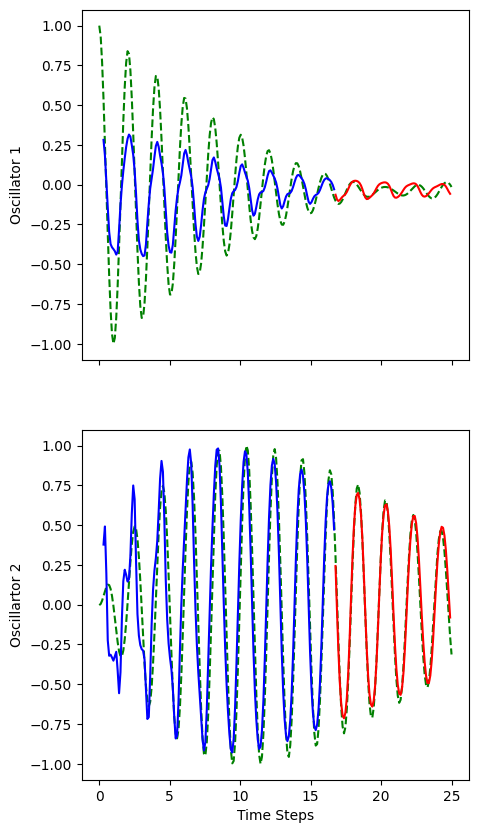

Epoch 31, Train Loss: 0.0333, Test Loss: 0.0169
Epoch 32, Train Loss: 0.0305, Test Loss: 0.0170
Epoch 33, Train Loss: 0.0280, Test Loss: 0.0170
Epoch 34, Train Loss: 0.0258, Test Loss: 0.0170
Epoch 35, Train Loss: 0.0238, Test Loss: 0.0171
Epoch 36, Train Loss: 0.0222, Test Loss: 0.0171
Epoch 37, Train Loss: 0.0208, Test Loss: 0.0171
Epoch 38, Train Loss: 0.0196, Test Loss: 0.0172
Epoch 39, Train Loss: 0.0185, Test Loss: 0.0172
Epoch 40, Train Loss: 0.0177, Test Loss: 0.0172
Epoch 41, Train Loss: 0.0170, Test Loss: 0.0172
Epoch 42, Train Loss: 0.0164, Test Loss: 0.0172
Epoch 43, Train Loss: 0.0158, Test Loss: 0.0172
Epoch 44, Train Loss: 0.0153, Test Loss: 0.0171
Epoch 45, Train Loss: 0.0149, Test Loss: 0.0171
Epoch 46, Train Loss: 0.0145, Test Loss: 0.0170
Epoch 47, Train Loss: 0.0141, Test Loss: 0.0170
Epoch 48, Train Loss: 0.0138, Test Loss: 0.0169
Epoch 49, Train Loss: 0.0135, Test Loss: 0.0168
Epoch 50, Train Loss: 0.0132, Test Loss: 0.0168


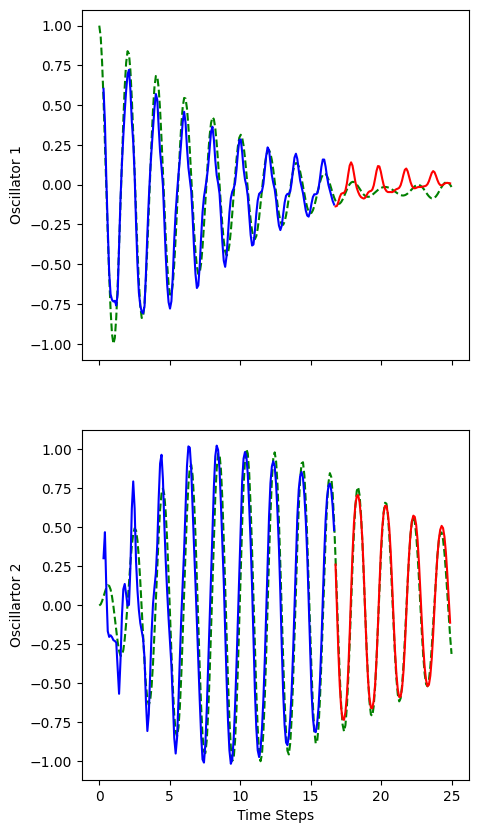

Epoch 51, Train Loss: 0.0129, Test Loss: 0.0167
Epoch 52, Train Loss: 0.0126, Test Loss: 0.0165
Epoch 53, Train Loss: 0.0124, Test Loss: 0.0164
Epoch 54, Train Loss: 0.0121, Test Loss: 0.0163
Epoch 55, Train Loss: 0.0119, Test Loss: 0.0161
Epoch 56, Train Loss: 0.0117, Test Loss: 0.0159
Epoch 57, Train Loss: 0.0115, Test Loss: 0.0158
Epoch 58, Train Loss: 0.0113, Test Loss: 0.0156
Epoch 59, Train Loss: 0.0111, Test Loss: 0.0154
Epoch 60, Train Loss: 0.0109, Test Loss: 0.0152
Epoch 61, Train Loss: 0.0107, Test Loss: 0.0150
Epoch 62, Train Loss: 0.0105, Test Loss: 0.0148
Epoch 63, Train Loss: 0.0103, Test Loss: 0.0146
Epoch 64, Train Loss: 0.0102, Test Loss: 0.0144
Epoch 65, Train Loss: 0.0100, Test Loss: 0.0142
Epoch 66, Train Loss: 0.0098, Test Loss: 0.0139
Epoch 67, Train Loss: 0.0097, Test Loss: 0.0137
Epoch 68, Train Loss: 0.0095, Test Loss: 0.0135
Epoch 69, Train Loss: 0.0093, Test Loss: 0.0133
Epoch 70, Train Loss: 0.0092, Test Loss: 0.0131


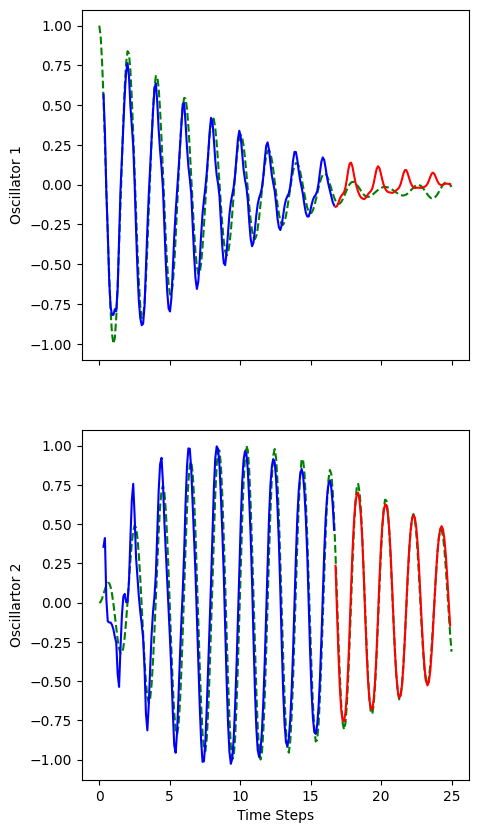

Epoch 71, Train Loss: 0.0090, Test Loss: 0.0128
Epoch 72, Train Loss: 0.0089, Test Loss: 0.0126
Epoch 73, Train Loss: 0.0087, Test Loss: 0.0124
Epoch 74, Train Loss: 0.0086, Test Loss: 0.0122
Epoch 75, Train Loss: 0.0085, Test Loss: 0.0119
Epoch 76, Train Loss: 0.0083, Test Loss: 0.0117
Epoch 77, Train Loss: 0.0082, Test Loss: 0.0115
Epoch 78, Train Loss: 0.0080, Test Loss: 0.0112
Epoch 79, Train Loss: 0.0079, Test Loss: 0.0110
Epoch 80, Train Loss: 0.0077, Test Loss: 0.0108
Epoch 81, Train Loss: 0.0076, Test Loss: 0.0105
Epoch 82, Train Loss: 0.0074, Test Loss: 0.0103
Epoch 83, Train Loss: 0.0073, Test Loss: 0.0101
Epoch 84, Train Loss: 0.0072, Test Loss: 0.0098
Epoch 85, Train Loss: 0.0070, Test Loss: 0.0096
Epoch 86, Train Loss: 0.0069, Test Loss: 0.0094
Epoch 87, Train Loss: 0.0067, Test Loss: 0.0092
Epoch 88, Train Loss: 0.0066, Test Loss: 0.0089
Epoch 89, Train Loss: 0.0064, Test Loss: 0.0087
Epoch 90, Train Loss: 0.0063, Test Loss: 0.0085
Epoch 91, Train Loss: 0.0062, Test Loss:

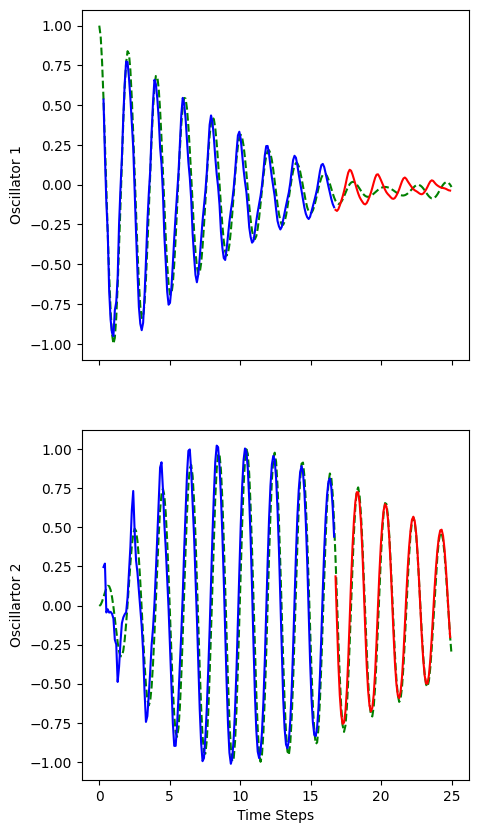

Train MAE OSC 1: 0.3126, Train RMSE OSC 1: 0.4325
Train MAE OSC 2: 0.1027, Train RMSE OSC 2: 0.1360
Test MAE OSC 1: 0.2540, Test RMSE OSC 1: 0.3024
Test MAE OSC 2: 0.1649, Test RMSE OSC 2: 0.1867


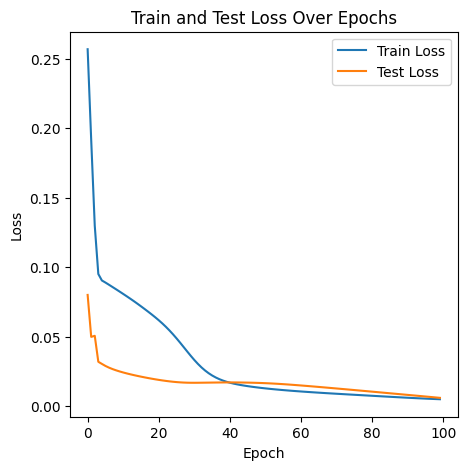

In [ ]:
from scipy.integrate import solve_ivp
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset

class GRUTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, output_size=1, num_layers=1, backend='default.qubit'):
        super(GRUTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize Quantum GRU or Classical GRU based on the presence of qubits
        if n_qubits > 0:
            print(f"Tagger will use Quantum GRU running on backend {backend}")
            self.gru = QGRU(args.input_size, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical GRU")
            self.gru = nn.GRU(input_size, hidden_dim, num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_dim, output_size)

    # use this forward class for qgru
    def forward(self, x):
        gru_out = self.gru(x)  # Get output from QGRU

        # Since gru_out is already 2D (batch_size, hidden_dim), use it directly
        out = gru_out

        # Pass the GRU output through the fully connected layer
        out = self.fc(out)
        return out

    # use this forward class for gru
    #def forward(self, x):
        # Pass input through the GRU layer
        #gru_output, _ = self.gru(x)


        # for each sequence in the batch
        #out = gru_output[:, -1, :]

        # Pass the GRU output through the fully connected layer
        #out = self.fc(out)
        #return out


batch_size = 64
class Args:
    hidden_dim = 4
    n_qubits = 4
    n_epochs = 100
    backend = 'default.qubit'
    learning_rate = 0.01
    sequence_length = 4
    sample_size = 250
    alpha = 0.99
    eps = 1e-8
    input_size = 2
args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"sample size: {args.sample_size}")
print(f"sequence length: {args.sequence_length}")
print(f"input size: {args.input_size}")

# Constants for the two coupled damped harmonic oscillators
g = 9.81  # gravitational constant
b1, b2 = 0.15, 0.15  # damping factors
l1, l2 = 1.0, 1.0   # lengths of the pendulums
m1, m2 = 1.0, 1.0  # masses
kc = 0.5  # coupling constant

# Initial conditions
theta1_0, theta2_0 = 0.0, 0.0  # initial angular displacements
theta_dot1_0, theta_dot2_0 = 3.0, 0.0  # initial angular velocities

# Differential equations for the two coupled damped oscillators (as pendulums)
def coupled_damped_pendulums(t, y):
    theta1, theta_dot1, theta2, theta_dot2 = y
    dtheta1_dt = theta_dot1
    dtheta_dot1_dt = -b1/m1 * theta_dot1 - g/l1 * np.sin(theta1) + kc/m1 * (theta2 - theta1)
    dtheta2_dt = theta_dot2
    dtheta_dot2_dt = -b2/m2 * theta_dot2 - g/l2 * np.sin(theta2) + kc/m2 * (theta1 - theta2)
    return [dtheta1_dt, dtheta_dot1_dt, dtheta2_dt, dtheta_dot2_dt]

# Time span and time steps for the simulation
t_span = (0, 25)
t_eval = np.linspace(t_span[0], t_span[1], 250)

# Solve the differential equations
sol = solve_ivp(coupled_damped_pendulums, t_span, [theta1_0, theta_dot1_0, theta2_0, theta_dot2_0], t_eval=t_eval)

# Extracting the angular velocities
angular_velocity_1 = sol.y[1]
angular_velocity_2 = sol.y[3]

def denormalize(norm_data, original_min, original_max):
    # Convert lists to numpy arrays for element-wise operations
    original_min = np.array(original_min)
    original_max = np.array(original_max)
    return norm_data * (original_max - original_min) + original_min

# Normalize the angular velocities
angular_velocity_1_normalized = 2 * (angular_velocity_1 - np.min(angular_velocity_1)) / (np.max(angular_velocity_1) - np.min(angular_velocity_1)) - 1
angular_velocity_2_normalized = 2 * (angular_velocity_2 - np.min(angular_velocity_2)) / (np.max(angular_velocity_2) - np.min(angular_velocity_2)) - 1

angular_velocity_1_min, angular_velocity_1_max = np.min(angular_velocity_1), np.max(angular_velocity_1)
angular_velocity_2_min, angular_velocity_2_max = np.min(angular_velocity_2), np.max(angular_velocity_2)
# Reshape the data for LSTM input
seq_length = 4
num_samples = len(t_eval) - seq_length + 1
input_size = 2

# Initialize data array
data = np.zeros((num_samples, seq_length, input_size))

# Populate the data array with sequences of angular velocities
for i in range(num_samples):
    data[i, :, 0] = angular_velocity_1_normalized[i:i+seq_length]
    data[i, :, 1] = angular_velocity_2_normalized[i:i+seq_length]


# Convert to a PyTorch tensor
data = torch.tensor(data, dtype=torch.float32)
input_sequences = data[:-1]
labels = data[1:, -1, :]
dataset = TensorDataset(input_sequences, labels)



# Calculate the index for the split
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

# Split the data into training and testing sets using the calculated index

# Calculate the sizes for training and testing sets
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

# Since it's a time series, we manually create subsets to maintain order
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = GRUTagger(input_size=args.input_size, hidden_dim=args.hidden_dim,
                   sequence_length=args.sequence_length, n_qubits=args.n_qubits,
                   output_size=2, backend=args.backend).float()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)
#optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, betas=(0.99, 0.9999), eps=args.eps, weight_decay=1e-3)



final_train_predictions = []
final_test_predictions = []
train_losses = []
test_losses = []

for i in range(3):
    print(f"Sequence {i}:")
    print(input_sequences[i])
    print(f"Corresponding label: {labels[i]}")
    print()



for epoch in range(1, args.n_epochs + 1):
    model.train()  # Set model to training mode
    epoch_train_losses = []

    # Iterate through batches provided by train_loader
    for inputs, labels in train_loader:

        #print("Batch input shape:", inputs.shape)  # Expected: [batch_size, seq_length, input_size]
        #print("Batch labels shape:", labels.shape)

        optimizer.zero_grad()
        outputs = model(inputs)

        #print("Batch output shape:", outputs.shape)

        # The outputs shape is expected to match the labels shape here
        loss = loss_function(outputs, labels)

        #print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Track average train loss

    # Evaluation on test data using test_loader
    model.eval()  # Set model to evaluation mode
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)  # Track average test loss

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")



    if epoch in [1, 2, 5, 10, 20, 30, 50, 70, 100]:
      model.eval()
      with torch.no_grad():
          train_preds = [model(batch[0].to(device)) for batch in train_loader]
          test_preds = [model(batch[0].to(device)) for batch in test_loader]


      train_preds = torch.cat(train_preds, dim=0)
      test_preds = torch.cat(test_preds, dim=0)

      # Assuming `sol.t` is a numpy array with the time steps corresponding to the dynamics
      x_original = sol.t

      fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharex=True)

      for osc in range(2):  # Oscillator features: 0 for x, 1 for y
          # Plot true dynamics
          axes[osc].plot(x_original, angular_velocity_1_normalized if osc == 0 else angular_velocity_2_normalized, 'g--', label='Harmonic Dynamics')

          # Calculate the correct starting index for predictions
          start_index = seq_length - 1
          end_index = start_index + len(train_preds)

          # Plot training predictions
          axes[osc].plot(x_original[start_index:end_index], train_preds[:, osc].cpu().numpy(), 'b', label='Train Predictions')

          # Calculate the correct indices for test predictions
          start_index = end_index
          end_index = start_index + len(test_preds)

          # Plot testing predictions
          axes[osc].plot(x_original[start_index:end_index], test_preds[:, osc].cpu().numpy(), 'r', label='Test Predictions')

          axes[osc].set_ylabel(f'Oscillator 1' if osc == 0 else f'Oscillartor 2')
          #axes[osc].legend()
          #axes[osc].grid(True)

      plt.xlabel('Time Steps')
      plt.show()








model.eval()

def calculate_metrics(true_labels_np, predictions_np):
    """Calculate MAE and RMSE metrics given true labels and predictions."""
    mae = mean_absolute_error(true_labels_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(true_labels_np, predictions_np))
    return mae, rmse

# Initialize lists to hold predictions
final_train_predictions = []
final_test_predictions = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        final_train_predictions.append(outputs)

    for inputs, labels in test_loader:
        outputs = model(inputs)
        final_test_predictions.append(outputs)

# Concatenate the list of tensors into a single tensor
final_train_predictions = torch.cat(final_train_predictions, dim=0)
final_test_predictions = torch.cat(final_test_predictions, dim=0)

# Concatenate all the labels from the DataLoader
train_labels = torch.cat([label for _, label in train_loader], dim=0)
test_labels = torch.cat([label for _, label in test_loader], dim=0)

# Move predictions and labels to CPU and convert to numpy arrays for metrics calculation
train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
final_train_predictions_np = final_train_predictions.cpu().numpy()
final_test_predictions_np = final_test_predictions.cpu().numpy()

# Splitting into X and Y components
train_labels_x = denormalize(train_labels_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
train_labels_y = denormalize(train_labels_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)
test_labels_x = denormalize(test_labels_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
test_labels_y = denormalize(test_labels_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)

final_train_predictions_x = denormalize(final_train_predictions_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
final_train_predictions_y = denormalize(final_train_predictions_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)
final_test_predictions_x = denormalize(final_test_predictions_np[:, 0], angular_velocity_1_min, angular_velocity_1_max)
final_test_predictions_y = denormalize(final_test_predictions_np[:, 1], angular_velocity_2_min, angular_velocity_2_max)

# Calculate MAE and RMSE for both train and test sets, separately for X and Y
train_mae_x, train_rmse_x = calculate_metrics(train_labels_x, final_train_predictions_x)
train_mae_y, train_rmse_y = calculate_metrics(train_labels_y, final_train_predictions_y)
test_mae_x, test_rmse_x = calculate_metrics(test_labels_x, final_test_predictions_x)
test_mae_y, test_rmse_y = calculate_metrics(test_labels_y, final_test_predictions_y)

# Output the metrics for denormalized predictions, separately for X and Y components
print(f'Train MAE OSC 1: {train_mae_x:.4f}, Train RMSE OSC 1: {train_rmse_x:.4f}')
print(f'Train MAE OSC 2: {train_mae_y:.4f}, Train RMSE OSC 2: {train_rmse_y:.4f}')
print(f'Test MAE OSC 1: {test_mae_x:.4f}, Test RMSE OSC 1: {test_rmse_x:.4f}')
print(f'Test MAE OSC 2: {test_mae_y:.4f}, Test RMSE OSC 2: {test_rmse_y:.4f}')



# Plotting training and test losses over epochs
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

